<a href="https://colab.research.google.com/github/Manuelaio/course_MG/blob/main/SVs_WGS-WES_final2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



>**Structural Variants analysis**

This tutorial explores differences in the performance of SV (CNV) discovery with WES and WGS data.We show the results of the tools used for SV discovery: 

*   Manta output for WGS 
*   Excavator2 for WES 

The files of the results include the following information for each SV detected:

* Genomic positions (chromosome,start,end)

*   SV size 

*   SV type (Deletion and Duplication) 

* Intersection with trueset (genomic positions and source technology, as DGV, 
Long Read etc..)






In [ ]:
Manta= read.table("https://raw.githubusercontent.com/Manuelaio/course_MG/main/Manta_ex_DGV.bed", stringsAsFactors = F, header=T)
head(Manta)

In [ ]:
Exca = read.table("https://raw.githubusercontent.com/Manuelaio/course_MG/main/Excavator_DGV_LR.bed", stringsAsFactors = F, header=T)
head(Exca)



The following table and plot show the number of Deletions and Duplications found respectively by Manta and Excavator2.


In [ ]:
library(dplyr)
library(ggplot2)
if (!require("gridExtra")) install.packages("gridExtra") 
library(gridExtra)
options(repr.plot.width=10, repr.plot.height=8)

cat("Results for Manta (WGS):")

tab1=Manta %>%
  group_by(type) %>% 
  summarise(n = n()); tab1
#mycol=c("#C06C84", "#6C5B7B")
cat("_________________________________\n\n")
cat("Results for Excavator2 (WES):")

tab2=Exca %>%
  group_by(type) %>% 
  summarise(n = n()); tab2
#mycol=c("#C06C84", "#6C5B7B")
cat("\n")
a = ggplot(tab1, aes(x=type, y= n)) + geom_col(fill= c("#C06C84", "#6C5B7B")) + ylab("number of variants") + ggtitle("Manta - WGS:") + ylim(0,4430) + theme(text=element_text(size=18)) 
b = ggplot(tab2, aes(x=type, y= n)) + geom_col(fill= c("#C06C84", "#6C5B7B")) + ylab("number of variants") + ggtitle("EXCAVATOR - WES:") + ylim(0,4430) + theme(text=element_text(size=18))

grid.arrange(a,b,nrow=1,ncol=2)



We considered as **True discovery finding** each SV intersecting the True-set, and as **False discovery finding** each SV without intersection with the True-set. For instance:
For instance: 



```
chrom	start	end	type	len	genotype	chrom_TS	start_TS	end_TS	type_TS	source	len_TS	overlap
chr1	1355234	1373911	DEL	18677	1	chr1	882968	5666143	DEL	LONG_READ	4783175	18677 #TRUE DISCOVERY
chr1	6235711	6249420	DEL	13709	1	.	-1	-1	.	.	.	0 #FALSE DISCOVERY 
```


Moreover, each SVs was classifed into three categories based on their size: 
* `< 1kb `
* `1kb =< size =< 10kb  `
* `> 10 kb`



In [ ]:
cat("Manta:")
Manta$evaluation= ifelse(Manta$overlap!=0, "TRUE_DISCOVERY","FALSE_DISCOVERY")
Manta$overlapLen= with(Manta, ifelse(len >= 10000 , ">10kb" , ifelse(len < 1000, "<1kb", "1-10kb")))
table(Manta$evaluation, Manta$type)


In [ ]:
cat("EXCAVATOR2:")
Exca$evaluation= ifelse(Exca$overlap!=0, "TRUE_DISCOVERY","FALSE_DISCOVERY")
Exca$overlapLen= with(Exca, ifelse(len >= 10000 , ">10kb" , ifelse(len < 1000, "<1kb", "1-10kb")))
table(Exca$evaluation, Exca$type)




These are the corresponding plots for **True discoveries** and **False discoveries** separated by size.







In [ ]:
options(repr.plot.width=18, repr.plot.height=6)

tab3= Manta %>%
  group_by(type, evaluation, overlapLen, genotype) %>% 
  summarise(n = n(), .groups ="drop")

tab3$overlapLen= factor(tab3$overlapLen, levels= c("<1kb","1-10kb",">10kb"))

a=ggplot(tab3, aes(x=type, y= n,fill= evaluation)) + geom_col() +  facet_grid(.~overlapLen) + ylab("number of variants") + ggtitle("Manta") +theme(text=element_text(size=18))


tab4= Exca %>%
  group_by(type, evaluation, overlapLen, genotype) %>% 
  summarise(n = n(), .groups ="drop")

tab4$overlapLen= factor(tab4$overlapLen, levels= c("<1kb","1-10kb",">10kb"))

b= ggplot(tab4, aes(x=type, y= n,fill= evaluation)) + geom_col() +  facet_grid(.~overlapLen) + ylab("number of variants") + ggtitle("Excavator2") + theme(text=element_text(size=18))

grid.arrange(a,b,nrow=1,ncol=2)



The following plot shows the number of **True discoveries** and **False discoveries** separated by genotype.


In [ ]:
ggplot(tab3, aes(x=type, y= n,fill= evaluation)) + geom_col() +  facet_grid(.~genotype) + ylab("number of variants") + theme(text=element_text(size=18)) + ggtitle ("WGS genotypes")



Now we load the true-set used to annotate SVs from Manta and Excavator2 separately. This set help us to calculate the number of **False Negative** which are not included in the two files. Once we have obtained the number of False Negatives we can calculate **Precision** and **Recall** as shown in the picture below:  


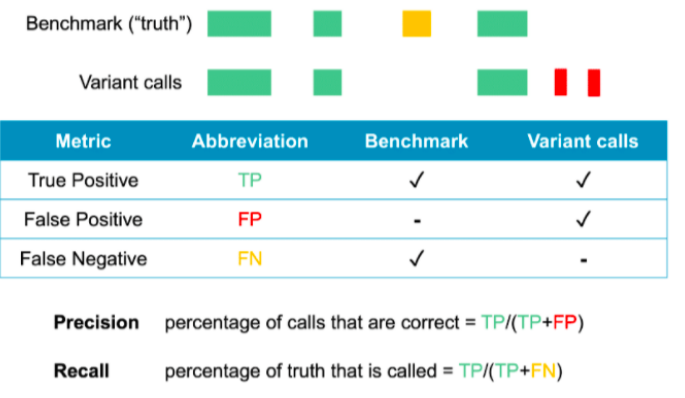

In [ ]:
trueset=read.table("https://raw.githubusercontent.com/Manuelaio/course_MG/main/NA12878_dgv_long_read_TRUESET.bed", stringsAsFactors = F)
head(trueset)

In [ ]:
PR_del <- function(data, data2){
  file.DEL= subset(data, type=="DEL")
  intersect.del= file.DEL[file.DEL$overlap!=0,]
 True.p= intersect.del[which(intersect.del$type==intersect.del$type_TS),]
 discordanti= intersect.del[which(intersect.del$type!=intersect.del$type_TS),]
 discordanti.na.omit= na.omit(discordanti)
 truset.del= subset(data2, V4=="DEL")
 TP= nrow(intersect.del[which(intersect.del$type==intersect.del$type_TS),])
 FN= (nrow(truset.del)) - TP - (nrow(discordanti.na.omit))
 FP= sum((nrow(file.DEL[file.DEL$overlap==0,])), (nrow(discordanti.na.omit)))
 PRECISIONE= ((TP)/(TP+FP))*100

 RECALL=  ((TP)/(TP+ abs(FN)))*100
 
 df <- data.frame(PRECISIONE,RECALL, TP, FN, FP)
 colnames(df) <- c("Precision","Recall","TP", "FN", "FP")
 return(df)
}


PR_dup <- function(data, data2){
  file.DUP= subset(data, type=="DUP")
  intersect.dup= file.DUP[file.DUP$overlap!=0,]
  True.p=intersect.dup[intersect.dup$type_TS=="DUP" | intersect.dup$type_TS=="INS",]
  discordanti_dup= intersect.dup[intersect.dup$type_TS=='DEL',]
  truset.dup= subset(data2, V4=="DUP")
  TP= nrow(True.p)
  FN= (nrow(truset.dup)) - TP - (nrow(discordanti_dup))
  FP= sum((nrow(file.DUP[file.DUP$overlap==0,])), (nrow(discordanti_dup)))
  PRECISIONE= ((TP)/(TP+FP))*100
  RECALL=  ((TP)/(TP+ abs(FN)))*100
  df <- data.frame(PRECISIONE,RECALL, TP, FN, FP)
 colnames(df) <- c("Precision","Recall","TP", "FN", "FP")
 return(df)
  
}

cat("Precision/Recall for Manta:\n\n")
PR_del(Manta, trueset)
PR_dup(Manta, trueset)
cat("\n________________________________\n\n")
cat("Precision/Recall for Excavator2:\n\n")
PR_del(Exca, trueset)
PR_dup(Exca, trueset)

In this final plot, we compare the F score `(2*((precision*recall)/(precision+recall)))` in Manta and Excavator2. 

In [ ]:
DEL1 = PR_del(Manta, trueset)
DEL1$caller = "Manta"
DEL2 = PR_del(Exca, trueset)
DEL2$caller = "Excavator2"
DEL_all = merge(DEL1,DEL2, by=c("Precision","Recall","TP","FN","FP","caller"), all=T)
DUP1 = PR_dup(Manta, trueset)
DUP1$caller = "Manta"
DUP2 = PR_dup(Exca, trueset)
DUP2$caller = "Excavator2"
DUP_all = merge(DUP1,DUP2, by=c("Precision","Recall","TP","FN","FP","caller"), all=T)

DEL_all$Precision= DEL_all$Precision/100; DEL_all$Recall= DEL_all$Recall/100
DUP_all$Precision= DUP_all$Precision/100; DUP_all$Recall= DUP_all$Recall/100

xlab="Precision"
ylab<-"Recall"
par(mfrow=c(1,2))
plot(DEL_all$Precision,DEL_all$Recall,xlim=c(0,1),ylim=c(0,1),col=c("lightseagreen","magenta"),pch=c(17,19),main="Precision-Recall  DELETIONS",cex=1.5,xlab=xlab,ylab=ylab)
legend("topleft", legend=c("Excavator", "Manta"),
       col=c("lightseagreen","magenta"), pch=c(17,19), box.lwd=par(1))
P<-seq(0.05,2,by=0.001)
FVec<-seq(0.1,0.9,by=0.1)
for (i in 1:9)
{
  
  F<-FVec[i]
  R<-F*P/(2*P-F)
  if (i!=9 & i!=7)
  {
    lines(P,R,col="gray80")
  }
  if (i==9)
  {
    lines(P[700:1000],R[700:1000],col="gray80")
  }
  if (i==7)
  {
    lines(P[400:1000],R[400:1000],col="gray80")
  }
}
text(0.05,0.1,"f=0.1",col="gray80")
text(0.15,0.2,"f=0.2",col="gray80")
text(0.25,0.3,"f=0.3",col="gray80")
text(0.35,0.4,"f=0.4",col="gray80")
text(0.45,0.5,"f=0.5",col="gray80")
text(0.55,0.6,"f=0.6",col="gray80")
text(0.65,0.7,"f=0.7",col="gray80")
text(0.75,0.8,"f=0.8",col="gray80")
text(0.85,0.9,"f=0.9",col="gray80")

plot(DUP_all$Precision,DUP_all$Recall,xlim=c(0,1),ylim=c(0,1),col=c("lightseagreen","magenta"),pch=c(17,19),main="Precision-Recall  DUPLICATIONS",cex=1.5,xlab=xlab,ylab=ylab)
legend("topleft", legend=c("Excavator", "Manta"),
       col=c("lightseagreen","magenta"), pch=c(17,19), box.lwd=par(1))
P<-seq(0.05,2,by=0.001)
FVec<-seq(0.1,0.9,by=0.1)
for (i in 1:9)
{
  
  F<-FVec[i]
  R<-F*P/(2*P-F)
  if (i!=9 & i!=7)
  {
    lines(P,R,col="gray80")
  }
  if (i==9)
  {
    lines(P[700:1000],R[700:1000],col="gray80")
  }
  if (i==7)
  {
    lines(P[400:1000],R[400:1000],col="gray80")
  }
}
text(0.05,0.1,"f=0.1",col="gray80")
text(0.15,0.2,"f=0.2",col="gray80")
text(0.25,0.3,"f=0.3",col="gray80")
text(0.35,0.4,"f=0.4",col="gray80")
text(0.45,0.5,"f=0.5",col="gray80")
text(0.55,0.6,"f=0.6",col="gray80")
text(0.65,0.7,"f=0.7",col="gray80")
text(0.75,0.8,"f=0.8",col="gray80")
text(0.85,0.9,"f=0.9",col="gray80")

